In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import datetime
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

In [86]:
train = pd.read_csv('../data/raw/application_train.csv')

In [87]:
train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0           24700.5  ...                 0                0                0   
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0                        0.0                       0.0   
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

In [88]:
features = train.iloc[:, 2:]

In [89]:
features = features.fillna(0)

In [90]:
def categorial_transporm(data):
    categorials = []
    for i in data.columns: 
        if len(data[i].value_counts()) < 9:
            categorials.append(i)
#             print(i, '--------------', len(data[i].value_counts()))
    return(categorials)

In [91]:
categorials = categorial_transporm(features)
categorials.append('WALLSMATERIAL_MODE')
categorials.append('OCCUPATION_TYPE')
categorials.append('ORGANIZATION_TYPE')

In [92]:
features[categorials] = features[categorials].astype(str)
le = LabelEncoder()
features[categorials] = features[categorials].apply(lambda col: le.fit_transform(col))

In [93]:
multi_categorials = []
for i in categorials:
    if len(features[i].value_counts()) > 2:
        multi_categorials.append(i)

In [94]:
features[multi_categorials] = features[multi_categorials].astype(str)

In [95]:
onehot_encoder = OneHotEncoder(sparse=False, dtype = int)
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(features[multi_categorials]))

/home/alex/kaggle/credit/venv/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [96]:
encoded_categorical_columns = encoded_categorical_columns.drop(columns=2)

In [97]:
features = features.drop(columns = multi_categorials)

In [98]:
features = pd.concat([features, encoded_categorical_columns], axis=1, join='inner')

In [99]:
features.shape

(307511, 262)

In [100]:
features.columns = features.columns.astype(str)

In [101]:
binary_features_columns = []
for i in features.columns:
    k = features[i].apply(lambda x: (x == 0) or (x == 1)).sum()
    if k == features[i].shape[0]:
        binary_features_columns.append(i)

In [102]:
sc = StandardScaler()

In [103]:
old_list = features.columns

In [104]:
quantitative_list = features.columns.drop(binary_features_columns)

In [105]:
X = sc.fit_transform(features[quantitative_list])

In [106]:
X = pd.DataFrame(X)
X.columns = quantitative_list

In [107]:
features.loc[:, quantitative_list] = X.loc[:, quantitative_list]

In [108]:
features

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                        0             0                1     -0.577538   
1                        0             0                0     -0.577538   
2                        1             1                1     -0.577538   
3                        0             0                1     -0.577538   
4                        0             0                1     -0.577538   
...                    ...           ...              ...           ...   
307506                   0             0                0     -0.577538   
307507                   0             0                1     -0.577538   
307508                   0             0                1     -0.577538   
307509                   0             0                1     -0.577538   
307510                   0             0                0     -0.577538   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0               0.142129   -0.478095    -0.166065        -0.505662   
1               0.426792    1.725450     0.592710         1.600480   
2              -0.427196   -1.152888    -1.404507        -1.090025   
3              -0.142533   -0.711430     0.177929        -0.651753   
4              -0.199466   -0.213734    -0.361658        -0.067390   
...                  ...         ...          ...              ...   
307506         -0.047646   -0.855489     0.031080        -0.846541   
307507         -0.408219   -0.818594    -1.042195        -0.846541   
307508         -0.066623    0.195379     0.198110         0.127398   
307509          0.009287   -0.568757    -0.476219        -0.590882   
307510         -0.047646    0.188760     1.518514         0.370883   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  149  150  151  152  153  \
0                        -0.149452    1.506880  ...    0    0    0    0    0   
1                        -1.252750   -0.166821  ...    0    0    0    0    0   
2                        -0.783451   -0.689509  ...    0    0    0    0    0   
3                        -0.928991   -0.680114  ...    0    0    0    0    0   
4                         0.563570   -0.892535  ...    0    0    0    0    0   
...                            ...         ...  ...  ...  ...  ...  ...  ...   
307506                    0.845396    1.537586  ...    0    0    0    0    0   
307507                    0.310593   -1.085707  ...    0    0    0    0    0   
307508                   -1.147120    0.245417  ...    0    0    0    0    0   
307509                   -1.124635    0.934008  ...    0    0    0    0    0   
307510                    1.832942   -0.187674  ...    0    0    0    0    0   

        154  155  156  157  158  
0         0    0    0    0    0  
1         0    0    0    0    0  
2         0    0    0    0    0  
3         0    0    0    0    0  
4         0    0    0    0    0  
...     ...  ...  ...  ...  ...  
307506    0    0    0    0    0  
307507    0    0    0    0    1  
307508    0    0    0    0    0  
307509    0    0    0    0    0  
307510    0    0    0    0    0  

[307511 rows x 262 columns]

In [109]:
target = train.loc[:, 'TARGET']

### Cross-Validation

### Зависимость от глубины деревьев

In [110]:
kf = KFold(n_splits=5, shuffle=True )
max_depth_grid = [3, 5, 7, 10, 13, 15, 17, 20, 25, 30, 35, 40, 45, 50]
train_score = []
test_score = []
temp_train_score = []
temp_test_score = []

In [111]:
for max_depth in max_depth_grid:
    print(max_depth)
    start_time = datetime.datetime.now()
    clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', 
                             max_depth=max_depth, learning_rate=0.05, n_estimators=20)
    temp_train_score = []
    temp_test_score = []
    
    for train_index, test_index in kf.split(features, target):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target[train_index], target[test_index]
        clf.fit(X_train, y_train)
        temp_train_score.append(roc_auc_score( y_train, clf.predict_proba(X_train)[:,1]))
        temp_test_score.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    train_score.append(temp_train_score)
    test_score.append(temp_test_score)

train_score, test_score = np.asarray(train_score), np.asarray(test_score)
print("Best ROC-AUC score is {:.2f}% with {} max_depth".format(max(test_score.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_score.mean(axis=1))]))
    
    


3
5
7
10
13
15
17
20
25
30
35
40
45
50
Best ROC-AUC score is 73.11% with 13 max_depth


In [112]:
train_score.mean(axis=1)

array([0.71641382, 0.73634128, 0.73830541, 0.7385812 , 0.73848263,
       0.73835987, 0.73828655, 0.73834388, 0.73829549, 0.73830551,
       0.73845475, 0.73830441, 0.73843745, 0.73834347])

Text(0.5, 0, 'Max_depth')

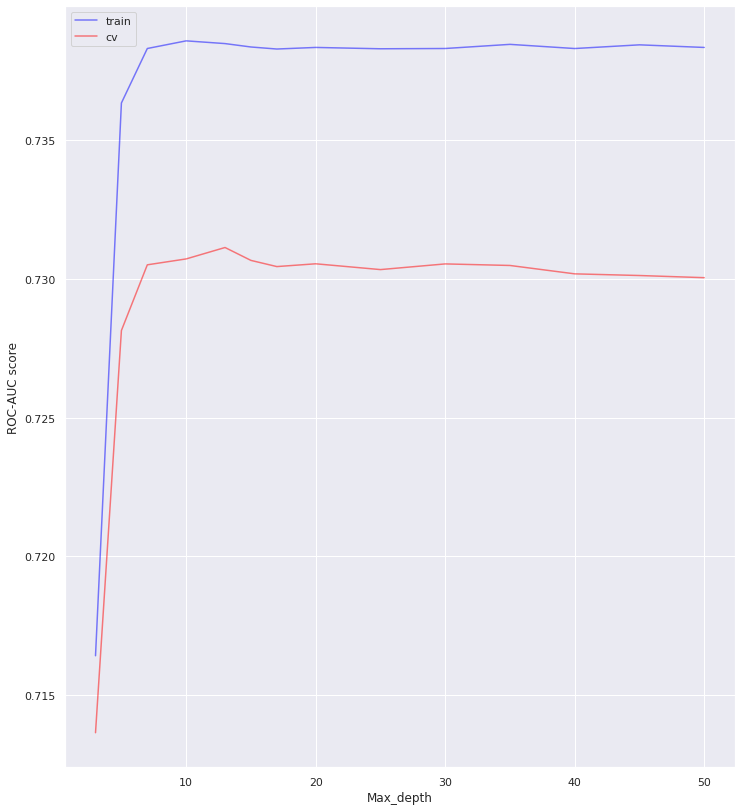

In [113]:
fig, ax = plt.subplots(figsize=(12, 14))
ax.plot(max_depth_grid, train_score.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_score.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.legend(loc='best')

ax.set_ylabel("ROC-AUC score")
ax.set_xlabel("Max_depth")

### Зависимость от минимального числа элементов в листе

In [114]:
kf = KFold(n_splits=5, shuffle=True )
min_samples_leaf_grid = [1, 3, 5, 7, 9, 10, 11, 13, 15, 17, 20, 22, 25]
train_score_leaf = []
test_score_leaf = []
temp_train_score_leaf = []
temp_test_score_leaf = []

In [115]:
for min_samples_leaf in min_samples_leaf_grid:
    print(min_samples_leaf)
    start_time = datetime.datetime.now()
    clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', 
                             max_depth=13,min_data_in_leaf = min_samples_leaf, learning_rate=0.05, n_estimators=20)
    temp_train_score_leaf = []
    temp_test_score_leaf = []
    
    for train_index, test_index in kf.split(features, target):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target[train_index], target[test_index]
        clf.fit(X_train, y_train)
        temp_train_score_leaf.append(roc_auc_score( y_train, clf.predict_proba(X_train)[:,1]))
        temp_test_score_leaf.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    train_score_leaf.append(temp_train_score_leaf)
    test_score_leaf.append(temp_test_score_leaf)

train_score_leaf, test_score_leaf = np.asarray(train_score_leaf), np.asarray(test_score_leaf)
print("Best ROC-AUC is {:.2f}% with {} min_samples_leaf".format(max(test_score_leaf.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_score_leaf.mean(axis=1))]))
    
    


1
3
5
7
9
10
11
13
15
17
20
22
25
Best ROC-AUC is 73.09% with 9 min_samples_leaf


Text(0.5, 0, 'Min samples leaf')

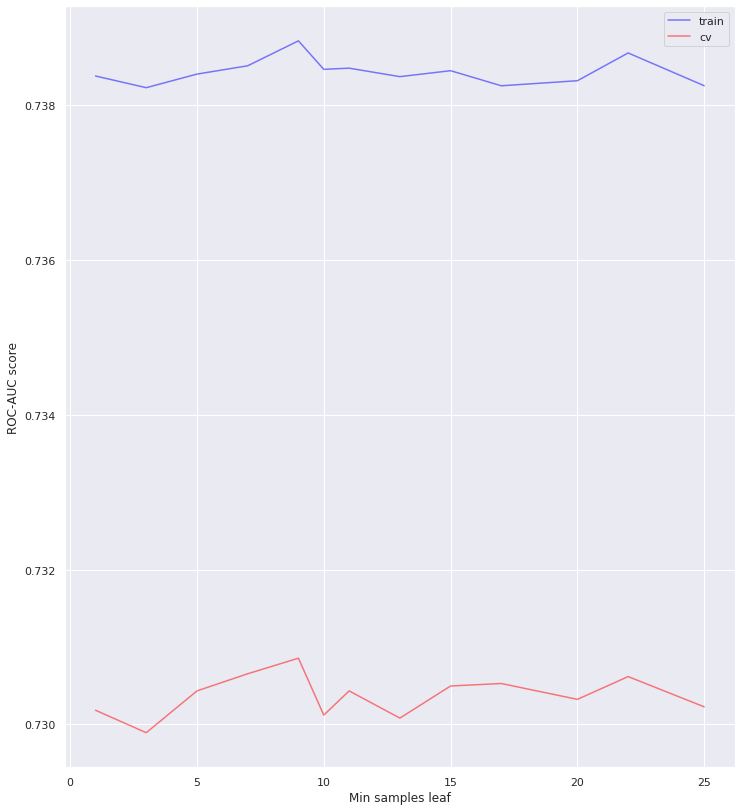

In [116]:
fig, ax = plt.subplots(figsize=(12, 14))
ax.plot(min_samples_leaf_grid, train_score_leaf.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_score_leaf.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.legend(loc='best')

ax.set_ylabel("ROC-AUC score")
ax.set_xlabel("Min samples leaf")

### Зависимость от learnbing rate

In [128]:
kf = KFold(n_splits=5, shuffle=True )
learning_rate_grid = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29]
train_score_learning_rate = []
test_score_learning_rate = []
temp_train_score_learning_rate = []
temp_test_score_learning_rate = []

In [129]:
for learning_rate in learning_rate_grid:
    print(learning_rate)
    start_time = datetime.datetime.now()
    clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', 
                             max_depth=13, min_data_in_leaf = 9, learning_rate=learning_rate, n_estimators=20)
    temp_train_score_learning_rate = []
    temp_test_score_learning_rate = []
    
    for train_index, test_index in kf.split(features, target):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target[train_index], target[test_index]
        clf.fit(X_train, y_train)
        temp_train_score_learning_rate.append(roc_auc_score( y_train, clf.predict_proba(X_train)[:,1]))
        temp_test_score_learning_rate.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    train_score_learning_rate.append(temp_train_score_learning_rate)
    test_score_learning_rate.append(temp_test_score_learning_rate)

train_score_learning_rate, test_score_learning_rate = np.asarray(train_score_learning_rate), np.asarray(test_score_learning_rate)
print("Best ROC-AUC is {:.2f}% with {} learning_rate".format(max(test_score_learning_rate.mean(axis=1))*100, 
                                                        learning_rate_grid[np.argmax(test_score_learning_rate.mean(axis=1))]))
    

0.01
0.03
0.05
0.07
0.09
0.11
0.13
0.15
0.17
0.19
0.21
0.23
0.25
0.27
0.29
Best ROC-AUC is 75.06% with 0.25 learning_rate


Text(0.5, 0, 'Learning rate')

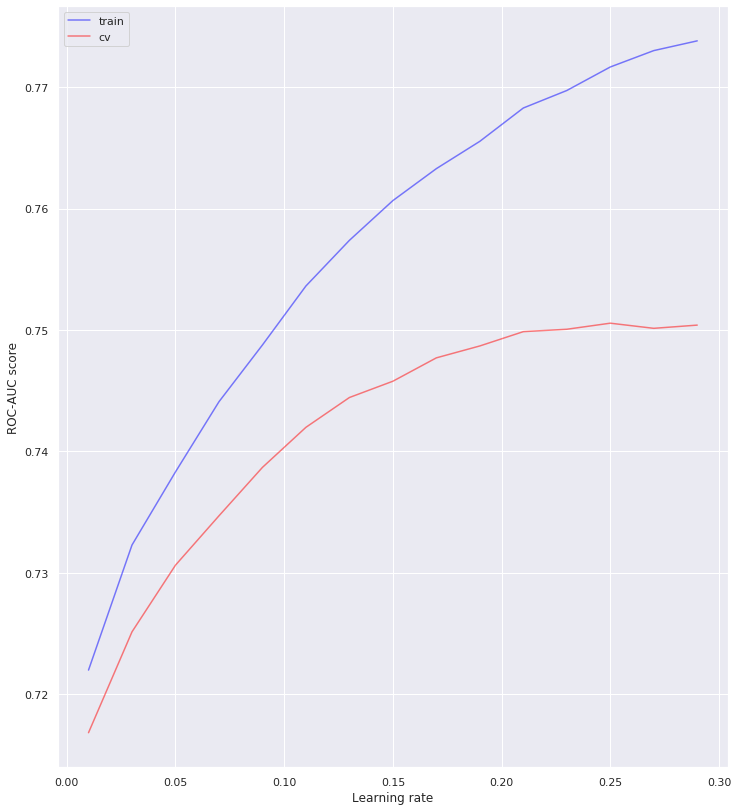

In [131]:
fig, ax = plt.subplots(figsize=(12, 14))
ax.plot(learning_rate_grid, train_score_learning_rate.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(learning_rate_grid, test_score_learning_rate.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.legend(loc='best')

ax.set_ylabel("ROC-AUC score")
ax.set_xlabel("Learning rate")

### Зависимость от n estimators

In [147]:
kf = KFold(n_splits=5, shuffle=True )
n_estimators_grid = [ 1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 50, 100, 150, 200, 250, 300, 350, 400, 450]
train_score_n_estimators = []
test_score_n_estimators = []
temp_train_score_n_estimators = []
temp_test_score_n_estimators = []

In [148]:
for n_estimators in n_estimators_grid:
    print(n_estimators)
    start_time = datetime.datetime.now()
    clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', 
                             max_depth=13, min_data_in_leaf = 9, learning_rate=0.15, n_estimators=n_estimators)
    temp_train_score_n_estimators = []
    temp_test_score_n_estimators = []
    
    for train_index, test_index in kf.split(features, target):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target[train_index], target[test_index]
        clf.fit(X_train, y_train)
        temp_train_score_n_estimators.append(roc_auc_score( y_train, clf.predict_proba(X_train)[:,1]))
        temp_test_score_n_estimators.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    train_score_n_estimators.append(temp_train_score_n_estimators)
    test_score_n_estimators.append(temp_test_score_n_estimators)

train_score_n_estimators, test_score_n_estimators = np.asarray(train_score_n_estimators), np.asarray(test_score_n_estimators)
print("Best ROC-AUC is {:.2f}% with {} learning_rate".format(max(test_score_n_estimators.mean(axis=1))*100, 
                                                        n_estimators_grid[np.argmax(test_score_n_estimators.mean(axis=1))]))
    

1
3
5
10
15
20
25
30
35
40
45
50
50
100
150
200
250
300
350
400
450
Best ROC-AUC is 75.45% with 50 learning_rate


Text(0.5, 0, 'N estimators')

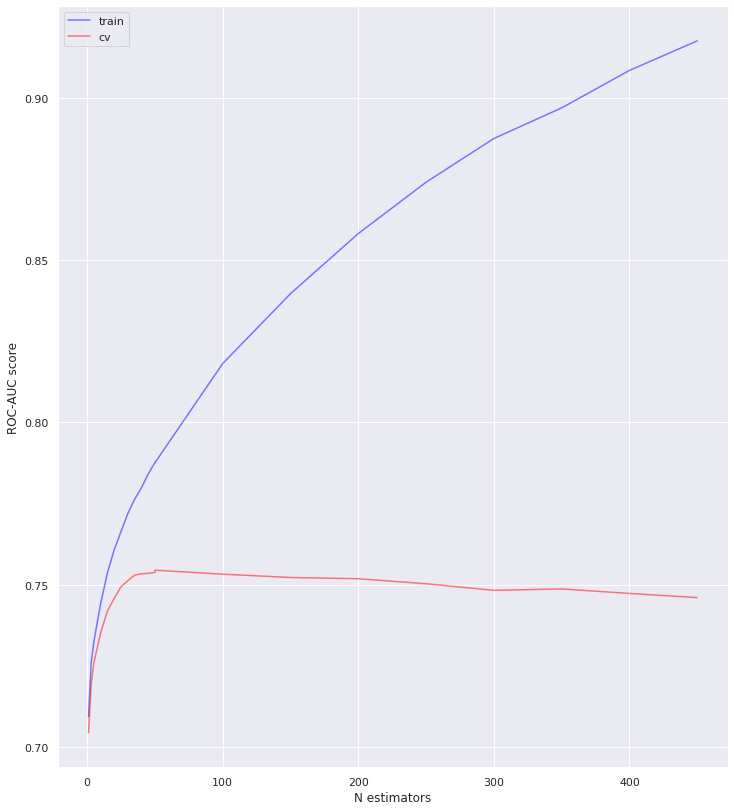

In [149]:
fig, ax = plt.subplots(figsize=(12, 14))
ax.plot(n_estimators_grid, train_score_n_estimators.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(n_estimators_grid, test_score_n_estimators.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.legend(loc='best')

ax.set_ylabel("ROC-AUC score")
ax.set_xlabel("N estimators")

### Настроим гиперпараметры в модели

In [156]:
parameters = {'n_estimators': [20, 50, 100, 200], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [3, 5, 10, 15], 
              'learning_rate': [0.05, 0.1, 0.15, 0.25]}
clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')

gbm = GridSearchCV(clf, parameters, cv=kf, scoring = 'roc_auc')
gbm.fit(features, target)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      metric='binary_logloss',
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1...
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                         

In [157]:
print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200}


In [158]:
print('Best score:', gbm.best_score_)

Best score: 0.7584243998997546
